In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import tifffile as tf
import numpy as np
import os
from netCDF4 import Dataset
import rasterio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp 
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm
import yaml
import cartopy
import cartopy.crs as ccrs
#import descartes # required to plot polygons
import cartopy.io.img_tiles as cimgt


ModuleNotFoundError: No module named 'cartopy.crs'

In [4]:
# User defined settings for pathogen and scenario selection

pathogen = 'E.coli' # select the pathogen for the simulation. Option at the moment is only 'E.coli'
source = 'Sewer_and_pluvial' #select the source of the pathogen. At the moment only 'Sewer_and_pluvial'
conc = 'max' #select the concentration of the pathogen: options are 'min' and 'max'
doseresp = 'poisson' #select the dose response curve of the pathogen for infection calculation. Either 'beta poisson' (keyword: 'poisson') or exponantial ('exp', not yet included)

#form values for poisson distribution
N50 = 896 #constant for the beta poisson infection risk calculation
NoE  = 4  #number of events per year 
alpha = 0.145 #form value for poisson distribution

In [5]:
"""
with rasterio.open('pop_dens.tif') as src:
    window= rasterio.windows.Window(400, 525, 150, 150)
    subset = src.read(window=window)
    transform = src.window_transform(window)
    meta = src.meta.copy()
    meta.update({
        'height': window.height,
        'width': window.width,
        'transform': transform
    })

 
# Write the subset to a new file   
with rasterio.open('pop_dens_zoom.tif', 'w', **meta) as dst:
    dst.write(subset)

"""

"\nwith rasterio.open('pop_dens.tif') as src:\n    window= rasterio.windows.Window(400, 525, 150, 150)\n    subset = src.read(window=window)\n    transform = src.window_transform(window)\n    meta = src.meta.copy()\n    meta.update({\n        'height': window.height,\n        'width': window.width,\n        'transform': transform\n    })\n\n \n# Write the subset to a new file   \nwith rasterio.open('pop_dens_zoom.tif', 'w', **meta) as dst:\n    dst.write(subset)\n\n"

### read in maps & plot them

In [6]:
flood = tf.imread('flooded_zoom.tif')
fl = flood.copy()

fl=fl*10 #creating -inf instead of floating veeeery small number 
flooded = fl.copy()
flooded[np.isinf(flooded)] = np.nan
flooded = flooded/10 #setting values back
print(np.nanmin(flooded))
print(np.nanmax(flooded))

-10.4919195
11.578357


C:\Users\bleser\AppData\Local\Temp\ipykernel_21088\3882315716.py:4: RuntimeWarning: overflow encountered in multiply
  fl=fl*10 #creating -inf instead of floating veeeery small number


C:\Users\bleser\AppData\Local\Temp\ipykernel_21088\4175759298.py:8: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)


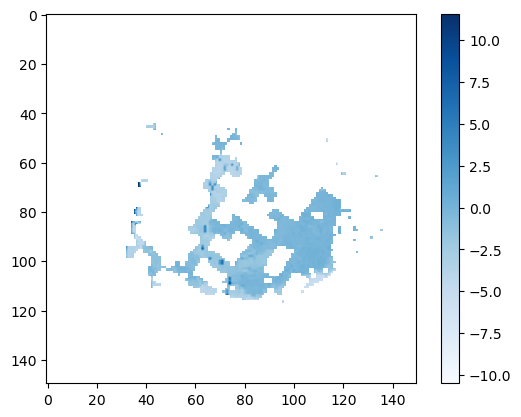

In [7]:
cmap = mpl.colormaps['Blues']
norm = plt.Normalize(vmin=np.nanmin(flooded), vmax=np.nanmax(flooded))
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots()

im = ax.imshow(flooded, cmap=cmap)
cbar = fig.colorbar(mappable)

plt.show()

In [8]:
"""
hist, bins = np.histogram(flooded, bins=10, range=(np.nanmin(flooded), np.nanmax(flooded)))

# Plot the histogram
plt.hist(flooded, bins=20, range=(np.nanmin(flooded),np.nanmax(flooded)))
plt.title("Histogram of flooding classes")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()
"""

'\nhist, bins = np.histogram(flooded, bins=10, range=(np.nanmin(flooded), np.nanmax(flooded)))\n\n# Plot the histogram\nplt.hist(flooded, bins=20, range=(np.nanmin(flooded),np.nanmax(flooded)))\nplt.title("Histogram of flooding classes")\nplt.xlabel("Value")\nplt.ylabel("Frequency")\nplt.show()\n'

In [9]:
popdenst = tf.imread('pop_dens_zoom.tif')
popd = popdenst.copy()
popd=popd*10 #creating -inf instead of floating veeeery small number 
popdens = popd.copy()
popdens[np.isinf(popdens)] = np.nan
popdens = popdens/10 #setting values back

print(np.nanmax(popdens))
print(np.nanmin(popdens))

141.86479
4.25104


C:\Users\bleser\AppData\Local\Temp\ipykernel_21088\2845886501.py:3: RuntimeWarning: overflow encountered in multiply
  popd=popd*10 #creating -inf instead of floating veeeery small number


C:\Users\bleser\AppData\Local\Temp\ipykernel_21088\4118336793.py:8: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)


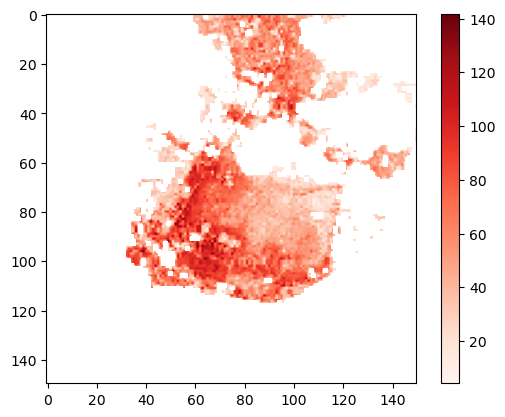

In [10]:
cmap = mpl.colormaps['Reds']
norm = plt.Normalize(vmin=np.nanmin(popdens), vmax=np.nanmax(popdens))
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots()

im = ax.imshow(popdens, cmap=cmap)
cbar = fig.colorbar(mappable)

plt.show()

### Visualize & calculate affected population

In [11]:
overl_flarea = np.where(flooded >= np.nanmin(flooded),popdens,np.nan)
overl_dryarea = np.where(np.isnan(flooded),popdens,np.nan)



C:\Users\bleser\AppData\Local\Temp\ipykernel_21088\3481121497.py:8: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)


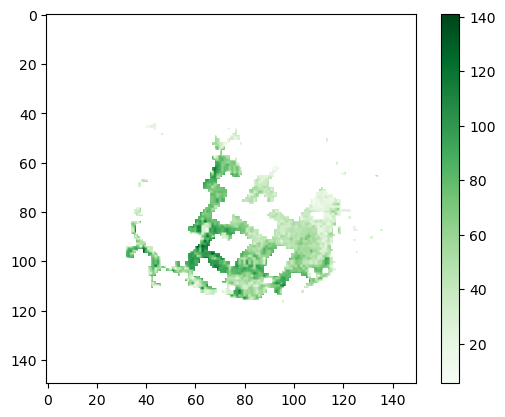

C:\Users\bleser\AppData\Local\Temp\ipykernel_21088\3481121497.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)


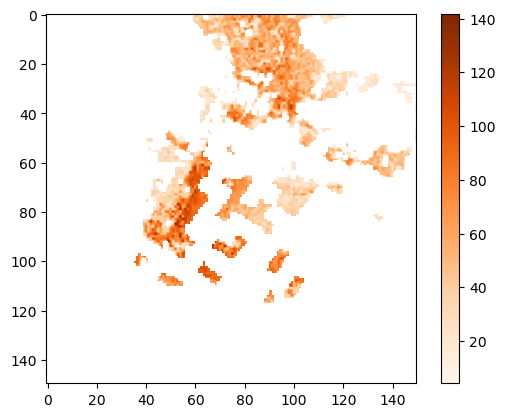

In [12]:
cmap = mpl.colormaps['Greens']
norm = plt.Normalize(vmin=np.nanmin(overl_flarea), vmax=np.nanmax(overl_flarea))
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots()

im = ax.imshow(overl_flarea, cmap=cmap)
cbar = fig.colorbar(mappable)

plt.show()

cmap = mpl.colormaps['Oranges']
norm = plt.Normalize(vmin=np.nanmin(overl_dryarea), vmax=np.nanmax(overl_dryarea))
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots()

im = ax.imshow(overl_dryarea, cmap=cmap)
cbar = fig.colorbar(mappable)

plt.show()

In [13]:
print('total inhabitants in total area:', round(np.nansum(popdens),0))
print('total inhabitants in flooded area:', round(np.nansum(overl_flarea),0), '(', round((np.nansum(overl_flarea)/np.nansum(popdens))*100,0),'%)')
print('total inhabitants in dry area:', round(np.nansum(overl_dryarea),0), '(', round((np.nansum(overl_dryarea)/np.nansum(popdens))*100,0),'%)')

total inhabitants in total area: 347166.0
total inhabitants in flooded area: 137904.0 ( 40.0 %)
total inhabitants in dry area: 209261.0 ( 60.0 %)


### Relate pathogen concentration to exposure levels
In this part, four flooding water depths are assumed: 0-0.10 (value 1), 0.1-0.5 (value 2),0.5-1.5 (value 3)and >1.5 (value 4). It is assumed that value 1 has no additional expore to not flooded, value 2 relates to wading of both children and adults, value 3 to swimming of children and wading by adults and value 4 both children and adults swim 


In [14]:
wclass = flooded.copy()
wclass[wclass>0]=np.nan
wclass[np.logical_and(wclass<0,wclass>=-0.1)]= 1
wclass[np.logical_and(wclass<-0.1,wclass>=-0.5)]=2
wclass[np.logical_and(wclass<-0.5,wclass>=-1.5)]=3
wclass[wclass<-1.5]= 4


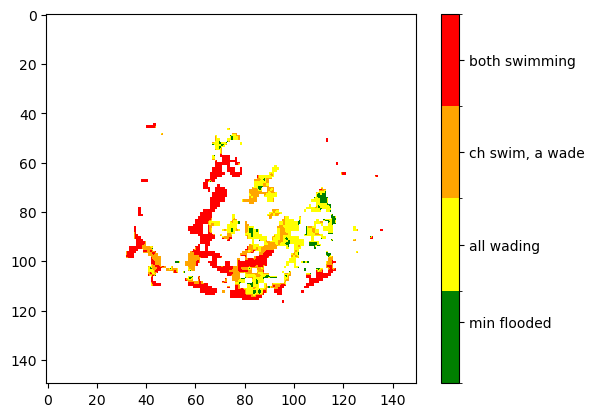

In [15]:
cmap = ListedColormap(['green', 'yellow', 'orange', 'red'])
bounds = [0, 1.5, 2.5, 3.5, 4.5]
norm = BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots()

im = ax.imshow(wclass, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ticks=[1,2, 3,4], boundaries=bounds)
cbar.ax.set_yticklabels(['min flooded', 'all wading', 'ch swim, a wade', 'both swimming'])
plt.show()

In [16]:
np.nansum(wclass[wclass==1])

194.0

In [17]:
# make distinction between adults&children
# together with population data you know how many in each class, which can be highlighted in maps
print('total inhabitants in minimum flooded area:', round(np.nansum(wclass[wclass==1]),0),'(',round((np.nansum(wclass[wclass==1])/np.nansum(wclass))*100,0),'%)')
print('total inhabitants in area where everyone is wading:', round(np.nansum(wclass[wclass==2]),0),'(',round((np.nansum(wclass[wclass==2])/np.nansum(wclass))*100,0),'%)')
print('total inhabitants in area where children swim and adults wade:', round(np.nansum(wclass[wclass==3]),0),'(',round((np.nansum(wclass[wclass==3])/np.nansum(wclass))*100,0),'%)')
print('total inhabitants in area where everyone is swimming:', round(np.nansum(wclass[wclass==4]),0),'(',round((np.nansum(wclass[wclass==4])/np.nansum(wclass))*100,0),'%)')

# exposure data should be read in from text file
# read in dose response relations (via text file - link to different modules)

total inhabitants in minimum flooded area: 194.0 ( 3.0 %)
total inhabitants in area where everyone is wading: 1416.0 ( 21.0 %)
total inhabitants in area where children swim and adults wade: 1494.0 ( 22.0 %)
total inhabitants in area where everyone is swimming: 3648.0 ( 54.0 %)


Import pathogen concentration with YAML file

In [20]:
# Read YAML file
with open('Scenarios_Pathogen.yml', 'r') as file:
    data = yaml.safe_load(file)

pathogen_name = 'E.coli'
source_name = 'Sewer_and_pluvial'
conc_type = 'min'

# Find the pathogen
selected_pathogen = None
for pathogen in data['pathogens']:
    if pathogen['name'] == pathogen_name:
        selected_pathogen = pathogen
        break

if selected_pathogen:
    print('Selected pathogen:', selected_pathogen['name'])

    # Find the scenario for the given source
    selected_scenario = None
    for scenario in selected_pathogen['scenarios']:
        if scenario['source'] == source_name:
            selected_scenario = scenario
            break

    if selected_scenario:
        print('Used source:', selected_scenario['source'])
        print('Used unit:', selected_scenario['units'])

        # Retrieve the concentration based on the conc_type
        if conc_type == 'min':
            concentration = selected_scenario['min_conc']
            print('Using minimum concentration:', concentration)
        elif conc_type == 'max':
            concentration = selected_scenario['max_conc']
            print('Using maximum concentration:', concentration)
        else:
            print('Invalid concentration type')
    else:
        print('No scenario found for the specified source')
else:
    print('No pathogen found with the specified name')

PatConc = float(concentration)
print(PatConc)



Selected pathogen: E.coli
Used source: Sewer_and_pluvial
Used unit: MPN/ml
Using minimum concentration: 1000
1000.0


Old script to read in Pathogen scenarios with text file

In [19]:
# read in pathogen concentrations & select concentration
file = open("Scenarios.txt", "r")
for line in file:
    if "E.coli" in line:
        Scenario = line.strip().split(',')
        #print(Scenario)
file.close()

# loops should be incorporated/or working with functions....

if Scenario[0]==pathogen:
    print('Selected pathogen:',Scenario[0])
    if Scenario[1]==source:
        print('used source:',Scenario[1])
        unit = Scenario[4]
        print('used unit:',unit)
        if conc=='min':
            PathConc = Scenario[2]
            print('Using minimum concentration:', PathConc)
        elif conc == 'max':
            PathConc = Scenario[3]
            print('Using maximum concentration:', PathConc)
        else:
            print('No concentration data found for the inserted scenario')

PathConc = float(PathConc.strip().strip("'"))

NameError: name 'PathConc' is not defined

In [ ]:
# Read exposure data from YAML file
with open("Exposure_scenarios.yml", "r") as file:
    exposure_data = yaml.safe_load(file)

# Retrieve concentration and unit for specific exposure scenarios
ad_sp = exposure_data["-Splashed_Adult"]["conc"]
ad_sw = exposure_data["-Swimming_Adult"]["conc"]
ch_pl = exposure_data["-Playing_Children"]["conc"]
ch_sw = exposure_data["-Swimming_Children"]["conc"]

unit_ad_sp = exposure_data["-Splashed_Adult"]["unit"]
unit_ad_sw = exposure_data["-Swimming_Adult"]["unit"]
unit_ch_pl = exposure_data["-Playing_Children"]["unit"]
unit_ch_sw = exposure_data["-Swimming_Children"]["unit"]

# Print the concentration and unit for the specific exposure scenarios
print("Splashed_Adult:")
print("  Concentration:", ad_sp)
print("  Unit:", unit_ad_sp)
print()

print("Swimming_Adult:")
print("  Concentration:", ad_sw)
print("  Unit:", unit_ad_sw)
print()

print("Playing_Children:")
print("  Concentration:", ch_pl)
print("  Unit:", unit_ch_pl)
print()

print("Swimming_Children:")
print("  Concentration:", ch_sw)
print("  Unit:", unit_ch_sw)
print()

# Perform dose calculations
dAd_sp = (PatConc / 1000) * ad_sp
dAd_sw = (PatConc/ 1000) * ad_sw
dCh_pl = (PatConc / 1000) * ch_pl
dCh_sw = (PatConc / 1000) * ch_sw

# Print the results
print(dAd_sp)
print(dAd_sw)
print(dCh_pl)
print(dCh_sw)

Splashed_Adult:
  Concentration: 10
  Unit: ml/event

Swimming_Adult:
  Concentration: 3.5
  Unit: ml/h

Playing_Children:
  Concentration: 30
  Unit: ml/d

Swimming_Children:
  Concentration: 50
  Unit: ml/h

10.0
3.5
30.0
50.0


In [ ]:
# read in exposure data & calculation of the dose
file = open("Exposure.txt", "r")
for line in file:
    if "E.coli" in line:
        Exposure = line.strip().split(',')
        print(Exposure)
file.close()

if Scenario[0]==pathogen:
    print('Selected pathogen:',Scenario[0])
    Ad_sp = float(Exposure[1].strip().strip("'"))
    Ad_sw = float(Exposure[2].strip().strip("'"))
    Ch_pl = float(Exposure[3].strip().strip("'"))
    Ch_sw = float(Exposure[4].strip().strip("'"))


dAd_sp = (PatConc/1000)*Ad_sp
dAd_sw = (PatConc/1000)*Ad_sw

dCh_pl = (PatConc/1000)*Ch_pl
dCh_sw = (PatConc/1000)*Ch_sw

print(dAd_sp)
print(dAd_sw)
print(dCh_pl)
print(dCh_sw)

['E.coli', '10', ' 30', ' 30', ' 50', ' #Splashed adult;swimming adult;playing children; swimming children']
10.0
30.0
30.0
50.0


In [ ]:
# display on map
wclass[wclass==1]=np.nan
dose_ad = wclass.copy()
dose_ad[np.logical_or(dose_ad==2,dose_ad==3)] = dAd_sp
dose_ad[dose_ad==4] = dAd_sw

dose_ch = wclass.copy()
dose_ch[dose_ch==2] = dCh_pl
dose_ch[np.logical_or(dose_ch==3,dose_ch==4)] = dCh_sw



C:\Users\bleser\AppData\Local\Temp\ipykernel_6704\1365893742.py:8: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)


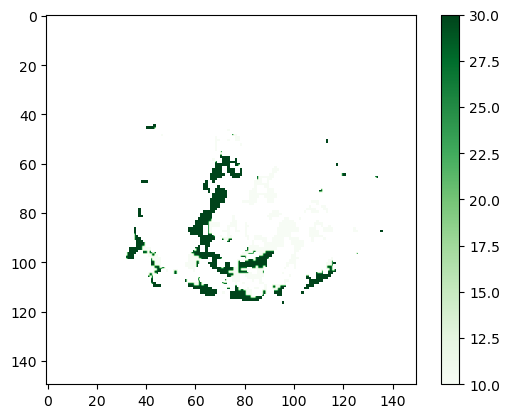

C:\Users\bleser\AppData\Local\Temp\ipykernel_6704\1365893742.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)


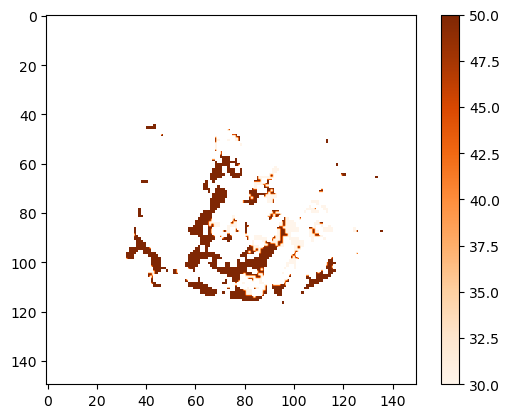

In [ ]:
cmap = mpl.colormaps['Greens']
norm = plt.Normalize(vmin=np.nanmin(dose_ad), vmax=np.nanmax(dose_ad))
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots()

im = ax.imshow(dose_ad, cmap=cmap)
cbar = fig.colorbar(mappable)

plt.show()

cmap = mpl.colormaps['Oranges']
norm = plt.Normalize(vmin=np.nanmin(dose_ch), vmax=np.nanmax(dose_ch))
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots()

im = ax.imshow(dose_ch, cmap=cmap)
cbar = fig.colorbar(mappable)

plt.show()

In [ ]:
InfRisk_Ad_sp = 1 - (1+(dAd_sp/N50)*(2**(1/alpha)-1))**-alpha
InfRisk_Ad_sw = 1 - (1+(dAd_sw/N50)*(2**(1/alpha)-1))**-alpha

InfRisk_Ch_pl = 1 - (1+(dCh_pl/N50)*(2**(1/alpha)-1))**-alpha
InfRisk_Ch_sw = 1 - (1+(dCh_sw/N50)*(2**(1/alpha)-1))**-alpha

print(InfRisk_Ad_sp)
print(InfRisk_Ad_sw)
print(InfRisk_Ch_pl)
print(InfRisk_Ch_sw)


0.1147961381595558
0.20711542215916856
0.20711542215916856
0.2546819255059928


In [ ]:
# display on map
inf_ad = wclass.copy()
inf_ad[np.logical_or(inf_ad==2,inf_ad==3)] = InfRisk_Ad_sp
inf_ad[inf_ad==4] = InfRisk_Ad_sw

inf_ch = wclass.copy()
inf_ch[inf_ch==2] =InfRisk_Ch_pl
inf_ch[np.logical_or(inf_ch==3,inf_ch==4)] = InfRisk_Ch_sw


C:\Users\bleser\AppData\Local\Temp\ipykernel_6704\1767858925.py:8: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)


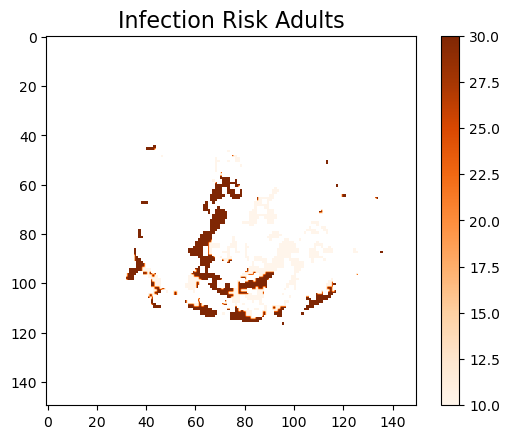

C:\Users\bleser\AppData\Local\Temp\ipykernel_6704\1767858925.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)


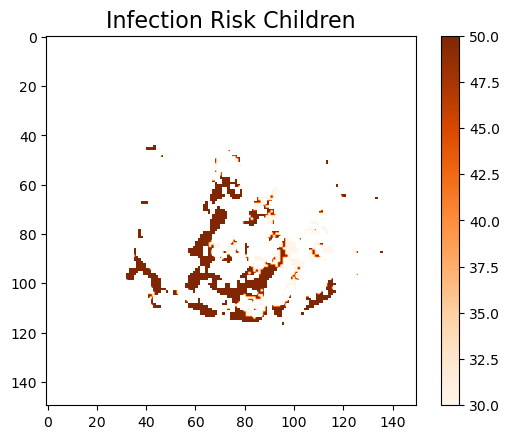

In [ ]:
cmap = mpl.colormaps['Oranges']
norm = plt.Normalize(vmin=np.nanmin(dose_ad), vmax=np.nanmax(dose_ad))
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots()
plt.title('Infection Risk Adults', fontsize=16, color='black')
im = ax.imshow(dose_ad, cmap=cmap)
cbar = fig.colorbar(mappable)

plt.show()

cmap = mpl.colormaps['Oranges']
norm = plt.Normalize(vmin=np.nanmin(dose_ch), vmax=np.nanmax(dose_ch))
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots()
plt.title('Infection Risk Children', fontsize=16, color='black')
im = ax.imshow(dose_ch, cmap=cmap)
cbar = fig.colorbar(mappable)

plt.show()


In [ ]:
#Estimate number of infections with infection risk for each exposure group per grid cell

#Multiply population in age groups with infection risk for each exposure group per grid cell
print(InfRisk_Ad_sp)
print(InfRisk_Ad_sw)
print(InfRisk_Ch_pl)
print(InfRisk_Ch_sw)

#multiply each grid cell with the infection risk

print('total inhabitants in minimum flooded area:', round(np.nansum(wclass[wclass==1]),0),'(',round((np.nansum(wclass[wclass==1])/np.nansum(wclass))*100,0),'%)')
print('total inhabitants in area where everyone is wading:', round(np.nansum(wclass[wclass==2]),0),'(',round((np.nansum(wclass[wclass==2])/np.nansum(wclass))*100,0),'%)')
print('total inhabitants in area where children swim and adults wade:', round(np.nansum(wclass[wclass==3]),0),'(',round((np.nansum(wclass[wclass==3])/np.nansum(wclass))*100,0),'%)')
print('total inhabitants in area where everyone is swimming:', round(np.nansum(wclass[wclass==4]),0),'(',round((np.nansum(wclass[wclass==4])/np.nansum(wclass))*100,0),'%)')

flooded_population_total = round(np.nansum(overl_flarea),0)
#flooded_children_sw =
#flooded_children_pl = 
#flooded_adults_wa = 
#flooded_adults_sw =  

print('Total Flooded Population:', flooded_population_total)
#print(flooded_children_pl)
#print(flooded_children_sw)
#print (flooded_adults_wa)
#print (flooded_adults_sw)

Infected_population = flooded_population_total * InfRisk_Ch_sw #max scenario for whole population, later distinction between vulnerability groups

print(Infected_population)


0.1147961381595558
0.20711542215916856
0.20711542215916856
0.2546819255059928
total inhabitants in minimum flooded area: 0.0 ( 0.0 %)
total inhabitants in area where everyone is wading: 1416.0 ( 22.0 %)
total inhabitants in area where children swim and adults wade: 1494.0 ( 23.0 %)
total inhabitants in area where everyone is swimming: 3648.0 ( 56.0 %)
Total Flooded Population: 137904.0
35121.65625497843


c:\Users\bleser\.conda\envs\floodshealth\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


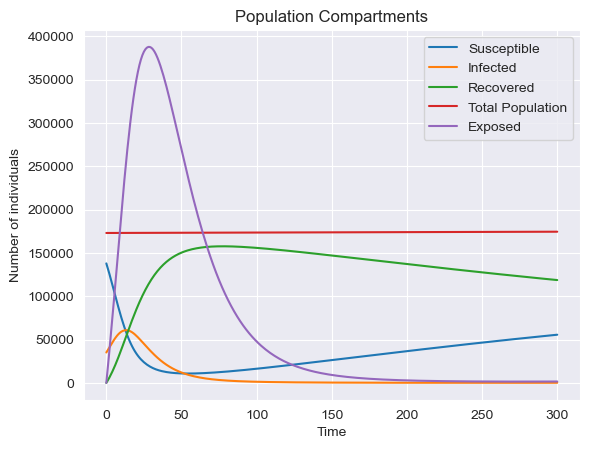

In [ ]:
#SIR model for V. cholera

# Parameters
b = 0.000072  # natural birth rates of humans per time, fixed value
betaB = 0.5  # ingestion rate of vibrio from environment, ranges between 0.001-0.5 for cholera
betaI = 0.2  # person to person infectivity, ranges between 0.001-0.5 for cholera
d = 0.000044  # natural death rates of humans per time, fixed value
delta = 0.05  # death rate of vibrios from HI to non-HI state, ranges between 0.025 - 0.33 for cholera
eta = 0.500  # rate of infected contribution to environmental vibrio concentration, ranges between 0.0001-10 for cholera
p_gamma = 0.08  # cholera recovery rate for infecteds, ranges between 1/14 - 1/7 for cholera. Used p_ to make a distinction between inbuild function and this parameter
p_kappa = 10E6 # half saturation constant of vibrio, fixed value. Used p_ to make a distinction between inbuild function and this parameter
omega = 0.0015  # rate of waning immunity from R to S, ranges between 0.00001-1/190 for cholera


# State variables
S = np.array([flooded_population_total]) # number of susceptible humans
I = np.array([Infected_population])  # number of infected humans
R = np.array([0.0])  # number of recovered humans ##changed from 1 to 0
N = np.array([S + I + R])  # total population in all human compartments #
B = np.array([10.0])  # concentration of vibrios in environment, unit so far unknown

# Parameters and state variables as a list
parameters = [b, betaB, betaI, d, delta, eta, p_gamma, p_kappa, omega]
states = [S, I, R, N, B]

# Define time
times = np.arange(0, 301, 301)  # in days or whatever timestep is suitable

# ODE function
def proc_ode(t, y, parameters):
    S, I, R, N, B = y
    b, betaB, betaI, d, delta, eta, p_gamma, p_kappa, omega = parameters

    dS = b * N - d * S - betaB * (B * S / (p_kappa + B)) - betaI * (S * I / N) + omega * R
    dI = -d * I + betaB * (B * S / (p_kappa + B)) + betaI * (S * I / N) - p_gamma *  I 
    dR = -d * R + p_gamma * I - omega * R
    dB = eta * I - delta * B
    dN = dS + dI + dR

    return [dS, dI, dR, dN, dB] #N and B are constants, no derivates

# Solve the ODEs
times = np.linspace(0, 300, 301)
initial_conditions = np.ravel(states) #convert to list and make y0 one-dimensional with np.ravel
solution = solve_ivp(proc_ode, [times[0], times[-1]], initial_conditions, t_eval=times, args=(parameters,))

# Convert the solution to a DataFrame
df_solution = pd.DataFrame(solution.y.T, columns=['S', 'I', 'R', 'N', 'B'])

# Plotting
sns.set_style('darkgrid')
plt.plot(times, df_solution['S'], label='Susceptible')
plt.plot(times, df_solution['I'], label='Infected')
plt.plot(times, df_solution['R'], label='Recovered')
plt.plot(times, df_solution['N'], label='Total Population')
plt.plot(times, df_solution['B'], label='Exposed')
plt.xlabel('Time')
plt.ylabel('Number of individuals')
plt.title('Population Compartments')
plt.legend()
plt.show()

In [ ]:
#DALY

#DALY = lost years of healthy life due to premature death and disability
#DALY is calculated by multiplying Yearly life lost due to disability (YLD) and Years of life lost (YLL) 
#Values are based on WHO tables for YLD and YLL 
#c=cause, s=sex, a=age, t=time

#DALY(c,s,a,t) = YLL(c,s,a,t) + YLD(c,s,a,t) 

#YLL is calculated by multiplying the number of deaths by the standard life expectancy at the age at which death occurs

#YLL = N * L(c,s,a,t) 

#YLL Diarrhea, all persons/no age/no gender/data from WHO 2019
YLL = 813.2

#YLD is calculated by multiplying the number of incident cases by the average duration of the disease and a disability weight that reflects the severity of the disease on a scale from 0 (perfect health) to 1 (equivalent to death)
#This could be changed by flood health model, added to yearly incident causes of diarrhea?

#YLD = I * DW(c,s,a,t) * D(c,s,a,t) 

#parameters Diarrhea
#global uncertainty for diarrhoeal diseases is 41.1% (WHO, 2019)

I= np.array([Infected_population])      #affected population per grid cell #
DW= 0.188                               #WHO disability weight for moderate diarrhea #Health state weight mild diarrhea: 0.074, moderate diarrhea: 0.188, severe diarrhea: 0.247
D= 2.5                                  #average duration of moderate diarrhea in days

YLD = I * DW * D

print(YLD)

DALY= YLL * YLD 

print(DALY)

[16507.17843984]
[13423637.50727777]
